In [13]:
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
""" PAC learning framework """

class Rectangle:
    def __init__(self, min_x, min_y, max_x, max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.width = max_x - min_x
        self.height = max_y - min_y

    def in_rectangle(self, X):
        return np.array((X[:,0] >= self.min_x) & (X[:,0] <= self.max_x) & (X[:,1] >= self.min_y) & (X[:,1] <= self.max_y))

def estimate_prob_of_target_rectangle(X, R_target):
    # Classify points
    labels = R_target.in_rectangle(X)

    # Estimate probability of unknown target concept with empirical probability
    # Size of data from normal distribution must be ceil((1.8595/eps)**2)
    p_hat = np.mean(labels)

    return p_hat

def generate_target_rectangle(X, eps):
    """ Generate unknown target concept that p_hat(c) >= 3*eps """

    print('[*] Generating concept from sample size: {}'.format(len(X)))

    while True:
        # Generate corner points of rectangle
        min_x = np.min(X[:,0])
        min_y = np.min(X[:,1])
        mid_x = np.median(X[:,0])
        mid_y = np.median(X[:,1])
        max_x = np.max(X[:,0])
        max_y = np.max(X[:,1])

        rect_min_x = random.randrange(int(min_x), int(mid_x))
        rect_min_y = random.randrange(int(min_y), int(mid_y))
        rect_max_x = random.randrange(int(mid_x), int(max_x))
        rect_max_y = random.randrange(int(mid_y), int(max_y))

        # Generate unknown target concept
        R_target = Rectangle(min_x=rect_min_x,
                             min_y=rect_min_y,
                             max_x=rect_max_x,
                             max_y=rect_max_y)

        # Estimate probability of unknown target concept with empirical probability
        # Size of data from normal distribution must be ceil((1.8595/eps)**2)
        p_hat = estimate_prob_of_target_rectangle(X, R_target)

        if p_hat >= 3*eps:
            print('[*] Requirement P(c) > {} is qualified. p_hat ({}) >= {}'.format(2*eps, p_hat, 3*eps))
            print('[*] Successfully generate concept.')
            return R_target
        else:
            print('[!] Requirement P(c) > {} is not qualified. p_hat ({}) < {}'.format(2*eps, p_hat, 3*eps))
            print('[!] Re-generate concept...')


def generate_hypothesis_rectangle(X, R_target):
    """ Algorithm for generating a good hypothesis from hypothesis set.
        In our case, the hypothesis set is same as the concept class,
        that is, all the possible rectangles in 2-D plane.
        Our goal is to learn a good rectangle that is approximate to our target unknown rectangle.
        Thus, our strategy is to select the "tightest" rectangle containing the points in our target unknown rectangle.
    """

    # print('[*] Generating hypothesis from sample size: {}'.format(len(X)))

    # Classify points
    labels = R_target.in_rectangle(X)

    # Select the tightest corner points in unknown target rectangle
    tight_rect_min_x = np.min(X[labels == 1, 0])
    tight_rect_min_y = np.min(X[labels == 1, 1])
    tight_rect_max_x = np.max(X[labels == 1, 0])
    tight_rect_max_y = np.max(X[labels == 1, 1])

    # Generate our good hypothesis
    R_hypothesis = Rectangle(min_x=tight_rect_min_x,
                             min_y=tight_rect_min_y,
                             max_x=tight_rect_max_x,
                             max_y=tight_rect_max_y)

    return R_hypothesis

def estimate_generalization_error(X, R_target, R_hypothesis):
    # print('[*] Estimating generalization error of hypothesis from sample size: {}'.format(len(X)))

    # Generate test true labels
    label_true = R_target.in_rectangle(X)

    # Make predictions
    label_pred = R_hypothesis.in_rectangle(X)

    # Misclassified labels
    label_error = (label_true != label_pred)

    # Calculate error
    generalization_error = np.mean(label_error)

    return generalization_error

In [15]:
""" Main """

# Arguments
delta = 0.01
eps = 0.1
mean_x = 0.0
mean_y = 0.0
std_x = 1.0
std_y = 1.0
r_xy = 0.5
mean = [mean_x, mean_y]
cov = [[std_x**2, r_xy*std_x*std_y], [r_xy*std_x*std_y, std_y**2]]

# Print arguments information
print('[*] Input arguments:')
print('    - delta: {}'.format(delta))
print('    - epsilon: {}'.format(eps))
print('    - mean_x: {}, mean_y: {}'.format(mean_x, mean_y))
print('    - std_x: {}, std_y: {}, r_xy: {}'.format(std_x, std_y, r_xy))
print('    - corvariance matrix: {}'.format(cov))

[*] Input arguments:
    - delta: 0.01
    - epsilon: 0.1
    - mean_x: 0.0, mean_y: 0.0
    - std_x: 1.0, std_y: 1.0, r_xy: 0.5
    - corvariance matrix: [[1.0, 0.5], [0.5, 1.0]]


[*] Generating concept from sample size: 346
[*] Requirement P(c) > 0.2 is qualified. p_hat (0.42196531791907516) >= 0.30000000000000004
[*] Successfully generate concept.


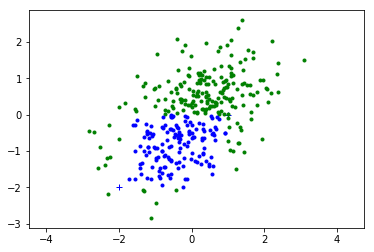

In [18]:
# Generate unknown target concept (axis-aligned rectangle) from sample size N
# Handle unknown target concept
N = int(math.ceil((1.8595/eps)**2))
X_N = np.random.multivariate_normal(mean=mean, cov=cov, size=N)

# Generate unknown target concept (axis-aligned rectangle) from sample size N
R_target = generate_target_rectangle(X_N, eps)

label_true = R_target.in_rectangle(X_N)

plt.plot([R_target.min_x, R_target.max_x], [R_target.min_y, R_target.max_y] , '+', c='b')
plt.plot(X_N[label_true == 0, 0], X_N[label_true == 0, 1], '.', c='g')
plt.plot(X_N[label_true == 1, 0], X_N[label_true == 1, 1], '.', c='b')
plt.axis('equal')
plt.show()

[*] Generalization error of hypothesis (0.014111304899318219)


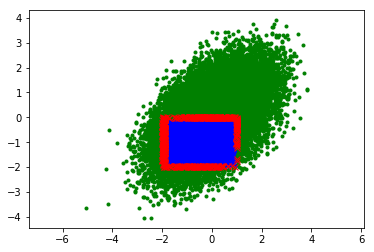

In [19]:
# Generate our good hypothesis to approximate unknown target concept from sample size m
m = int(math.ceil((4/eps) * math.log(4/delta)))
X_m = np.random.multivariate_normal(mean=mean, cov=cov, size=m)
R_hypothesis = generate_hypothesis_rectangle(X_m, R_target)

# Estimate generalization error of hypothesis
M = int(math.ceil((19.453/eps)**2))
X_M = np.random.multivariate_normal(mean=mean, cov=cov, size=M)

# Generate test true labels
label_true = R_target.in_rectangle(X_M)
# Make predictions
label_pred = R_hypothesis.in_rectangle(X_M)
# Misclassified labels
label_error = (label_true != label_pred)
# Calculate error
generalization_error = np.mean(label_error)

print('[*] Generalization error of hypothesis ({})'.format(generalization_error))

plt.plot(X_M[label_true == 1, 0], X_M[label_true == 1, 1], '.', c='b')
plt.plot(X_M[label_true == 0, 0], X_M[label_true == 0, 1], '.', c='g')
plt.plot(X_M[label_error == 1, 0], X_M[label_error == 1, 1], 'x', c='r')
plt.axis('equal')
plt.show()